In [1]:
from proglearn.sims import generate_gaussian_parity
from proglearn.forest import LifelongClassificationForest
import numpy as np
import matplotlib.pyplot as plt 
from sdtf import StreamDecisionForest

In [2]:
def get_posterior(clf_type, clf):
    p = np.arange(-3,3, step=0.01)
    q = np.arange(-3,3, step=0.01)
    xx,yy = np.meshgrid(p,q)
    grid_samples = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)),axis=1)
    if clf_type == "SYNF":
        posterior = clf.predict_proba(grid_samples, task_id=0)
    else: 
        posterior = clf.predict_proba(grid_samples)
    posterior = posterior[:,0].reshape(600,600)
    return posterior

In [3]:
def experiment(n, n_update):
    sdf_posteriors = []
    synf_posteriors = []
    sdf_error = []
    synf_error = []
    synf = LifelongClassificationForest(default_n_estimators=10)
    sdf = StreamDecisionForest(n_estimators=10)
    x,y = generate_gaussian_parity(n_update)
    test_x, test_y = generate_gaussian_parity(1000)
    synf.add_task(x,y,task_id=0, classes = [0,1])
    sdf.partial_fit(x,y,classes=[0,1])
    sdf_posteriors.append(get_posterior("SDF", sdf))
    synf_posteriors.append(get_posterior("SYNF", synf))
    sdf_error.append((1-np.mean(sdf.predict(test_x)==test_y)))
    synf_error.append((1-np.mean(synf.predict(test_x, task_id=0)==test_y)))
    for i in range(int(n/n_update)-1): 
        x,y = generate_gaussian_parity(n_update)
        synf.update_task(x,y, task_id = 0)
        sdf.partial_fit(x,y)
        sdf_posteriors.append(get_posterior("SDF", sdf))
        synf_posteriors.append(get_posterior("SYNF", synf))
        sdf_error.append((1-np.mean(sdf.predict(test_x)==test_y)))
        synf_error.append((1-np.mean(synf.predict(test_x, task_id=0)==test_y)))
    return sdf_posteriors, synf_posteriors, sdf_error, synf_error


def run_exp(n, n_update, mc_reps):
    sdf_p = []
    synf_p = []
    sdf_e = []
    synf_e = []
    for i in range(mc_reps):
        print(i)
        results = experiment(n, n_update)
        sdf_p.append(results[0])
        synf_p.append(results[1])
        sdf_e.append(results[2])
        synf_e.append(results[3])
    return np.mean(np.array(sdf_p),axis=0), np.mean(np.array(synf_p),axis=0),np.mean(np.array(sdf_e),axis=0), np.mean(np.array(synf_e),axis=0)
        


In [4]:
def plot_posteriors(sdf_results, synf_results, n_update):
    fig, axs = plt.subplots(nrows=2, ncols=sdf_results.shape[0], figsize=(20,4))
    for i in range(sdf_results.shape[0]):
        axs[0][i].imshow(sdf_results[i],interpolation="nearest", cmap="bwr")
        axs[1][i].imshow(synf_results[i],interpolation="nearest", cmap="bwr")
        axs[0][i].set_xticks([])
        axs[1][i].set_xticks([])
        axs[0][i].set_yticks([])
        axs[1][i].set_yticks([])
        axs[0][i].set_title("n: {}".format((i+1)*n_update))
    axs[0][0].set_ylabel("SDF")
    axs[1][0].set_ylabel("SYNF")

def plot_errors(sdf_errors, synf_errors, n_update, n):
    plt.plot(np.arange(n_update,n+n_update,n_update), sdf_errors, color = 'g', label = "SDF")
    plt.plot(np.arange(n_update,n+n_update,n_update), synf_errors, color = 'r', label = "SYNF")
    plt.legend()
    plt.xticks(np.arange(n_update,n+n_update,n_update))
    plt.ylabel("Error")
    plt.xlabel("samples")
    plt.title("XOR Error")

In [ ]:
n = 250
n_update = 25
mc_reps = 50
sdf_posteriors, synf_posteriors, sdf_errors, synf_errors = run_exp(n,n_update,mc_reps)

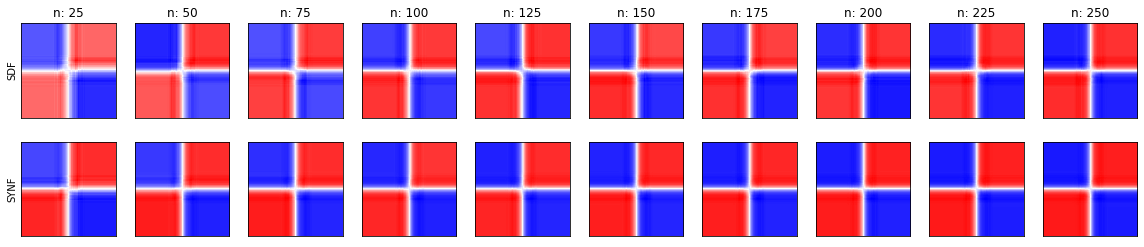

In [9]:
plot_posteriors(sdf_posteriors, synf_posteriors,n_update)


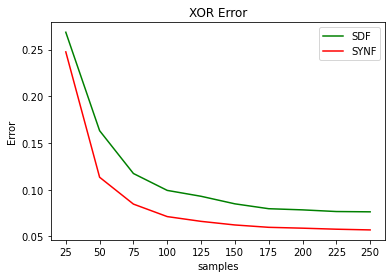

In [7]:
plot_errors(sdf_errors, synf_errors, n_update, n)